In [1]:
import sys; sys.path.insert(0, '../../external/')

import ira
%alphalab

from alpha.utils.data_helpers import FriendlyFxLoader

Reloaded ../../external/ira/experimental/c_simulator_core.pyx


In [2]:
from ira.simulator.SignalTester import Tracker
from ira.series.Indicators import ATR

from qlearn.tracking.trackers import TakeStopTracker, PipelineTracker, TimeExpirationTracker, DispatchTracker

In [3]:
fxl = FriendlyFxLoader('dukas @ 5Min')
data = fxl.ohlc('EURUSD')['2020':]

s = srows(
    pd.Series(-1, data[data.close > data.close.shift(6)].index),
    pd.Series(1, data[data.close < data.close.shift(6)].index)).sort_index().rename('EURUSD')

In [34]:
fi = [data.index.get_loc(i, method='pad') for i in data.index + pd.Timedelta('5H')]

In [74]:
prices = srows(data.open, data.close.shift(1, freq=pd.Timedelta('4Min59S')))

In [75]:
x = prices[:10]
x

time
2020-01-01 22:00:00    1.121460
2020-01-01 22:04:59    1.121380
2020-01-01 22:05:00    1.121380
2020-01-01 22:09:59    1.121430
2020-01-01 22:10:00    1.121425
2020-01-01 22:14:59    1.121395
2020-01-01 22:15:00    1.121385
2020-01-01 22:19:59    1.121485
2020-01-01 22:20:00    1.121475
2020-01-01 22:24:59    1.121550
dtype: float64

In [76]:

scols(x.reset_index(drop=True), x.asof(x.index + pd.Timedelta('15Min')).reset_index(drop=True))

,0,1
0,1.121460,1.121385
1,1.121380,1.121485
2,1.121380,1.121475
3,1.121430,1.121550
4,1.121425,1.121550
5,1.121395,1.121550
6,1.121385,1.121550
7,1.121485,1.121550
8,1.121475,1.121550
9,1.121550,1.121550


In [77]:
xf = (x.reset_index(drop=True) - x.asof(x.index + pd.Timedelta('15Min')).reset_index(drop=True))
xf.index = x.index
xf

time
2020-01-01 22:00:00    0.000075
2020-01-01 22:04:59   -0.000105
2020-01-01 22:05:00   -0.000095
2020-01-01 22:09:59   -0.000120
2020-01-01 22:10:00   -0.000125
2020-01-01 22:14:59   -0.000155
2020-01-01 22:15:00   -0.000165
2020-01-01 22:19:59   -0.000065
2020-01-01 22:20:00   -0.000075
2020-01-01 22:24:59    0.000000
dtype: float64

In [4]:
class VolatilityTracker(TakeStopTracker):
    def __init__(self, stop_factor=1, take_factor=2, debug=False):
        super().__init__(debug)
        self.stp_f = stop_factor
        self.tp_f = take_factor
        
    def initialize(self):
        self.h = self.get_ohlc_series('5Min')
        self.vol = ATR(24)
        self.h.attach(self.vol)

    def on_signal(self, signal_time, signal_qty, quote_time, bid, ask, bid_size, ask_size):
        v = self.vol[0]
        v = 0.0001 if np.isnan(v) else v
        signal_qty = int(signal_qty * 1000)

        if signal_qty != 0: #and np.sign(self._position.quantity)  np.sign(signal_qty) :
            stop_dp, take_dp = v * self.stp_f, v * self.tp_f
            self.stop_at(signal_time, self.h[0].low - stop_dp if signal_qty > 0 else self.h[0].high + stop_dp)
            self.take_at(signal_time, self.h[0].high + take_dp if signal_qty > 0 else self.h[0].low - take_dp)
            entry = ask if signal_qty > 0 else bid
            self.debug(f'\t[{quote_time} | {signal_time}] -> {self._position.quantity} / {self._instrument} {signal_qty} @ {entry:.5f} x {self.stop:.5f} + {self.take:.5f}')
        return signal_qty

In [5]:
t1 = VolatilityTracker(stop_factor=5, take_factor=2, debug=False)
p = z_backtest(shift_signals(s, '4Min59S'), {'EURUSD': data}, 'forex', 
               spread=fxl.spread('EURUSD'), execution_logger=True, trackers=t1)

2021-01-27 16:04:45,171 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2020-11-26 23:59:00.001000]


Statistic,Model
Gain (USD):,-30.81
CAGR (%):,-2.354
Sharpe:,-0.280
Sortino:,-0.413
Calmar:,-0.240
MaxDD (%):,10.161
MaxDD On Init BP (%):,10.310
MaxDD (USD):,103.100
MaxDD days:,176 days
MaxDD start:,2020-06-03

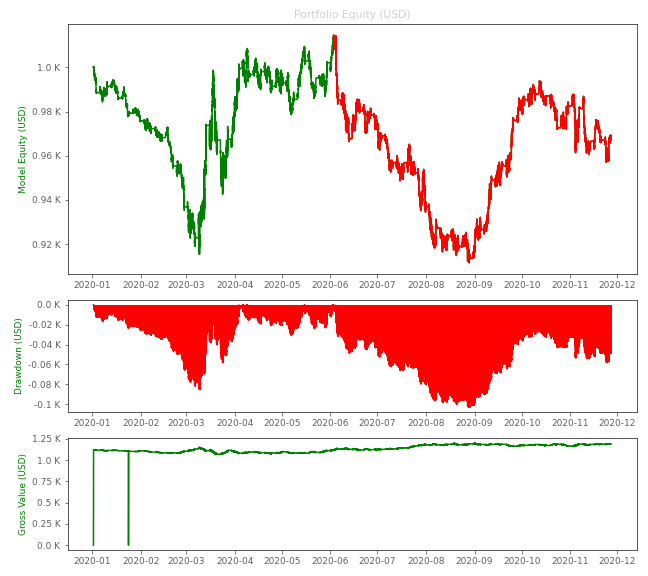

<Figure size 648x576 with 0 Axes>

In [6]:
tearsheet(p, 1000)

In [7]:
p.simulation_time

Timedelta('0 days 00:00:28.917137')

In [8]:
print(p.trackers_stat)

# Test trackers
<hr/>

Trackers pipeline test

In [9]:
class MyFixedPositionTracker(Tracker):
    def __init__(self, size):
        self.size = size
        
    def on_signal(self, signal_time, signal_qty, quote_time, bid, ask, bid_size, ask_size):
        return signal_qty * self.size

In [10]:
s = pd.DataFrame.from_dict({
    pd.Timestamp('2020-08-17 04:19:59'): {'EURUSD': +1},
    pd.Timestamp('2020-08-21 14:19:59'): {'EURUSD': -1},
    pd.Timestamp('2020-08-30 14:19:59'): {'EURUSD':  0},
}, orient='index')

p = z_backtest(s, {'EURUSD':data}, 'forex', spread=fxl.spread('EURUSD'), execution_logger=True, 
               trackers=PipelineTracker(
                   TimeExpirationTracker('1h', True),
                   MyFixedPositionTracker(10000))
              )

 > EURUSD position 10000 is expired at 2020-08-17 05:20:00
 > EURUSD position -10000 is expired at 2020-08-21 15:20:00


In [11]:
p.executions

,instrument,quantity,exec_price,comment
2020-08-17 04:19:59,EURUSD,10000,1.185496,
2020-08-17 05:20:00,EURUSD,-10000,1.185614,TimeExpirationTracker:: position 10000 is expired
2020-08-21 14:19:59,EURUSD,-10000,1.177144,
2020-08-21 15:20:00,EURUSD,10000,1.177786,TimeExpirationTracker:: position -10000 is exp...


Trackers dispatching test

In [12]:
class TrendFixedPositionTracker(TakeStopTracker):
    
    def __init__(self, size, tick_size):
        super().__init__(True)
        self.size = size
        self.tick_size = tick_size
        
    def on_signal(self, signal_time, signal_qty, quote_time, bid, ask, bid_size, ask_size):
        if signal_qty > 0:
            self.stop_at(signal_time, (bid+ask) / 2 - 50 * self.tick_size)
        elif signal_qty < 0:
            self.stop_at(signal_time, (bid+ask) / 2 + 50 * self.tick_size)
            
        return signal_qty * self.size

In [24]:
s = pd.DataFrame.from_dict({
    '2020-08-17 04:10:00': {'EURUSD': 'regime:trend'},
    '2020-08-17 04:19:59': {'EURUSD': +1},
    '2020-08-21 14:19:59': {'EURUSD': -1},
    '2020-08-21 14:55:59': {'EURUSD': +1},          # this should be flat !
    '2020-08-21 15:00:00': {'EURUSD': 'regime:mr'},
    '2020-08-21 18:19:59': {'EURUSD':  1},
    '2020-08-30 14:19:59': {'EURUSD':  0},
}, orient='index')

s.index = pd.DatetimeIndex(s.index)

p = z_backtest(s, {'EURUSD':data}, 'forex', spread=fxl.spread('EURUSD'), execution_logger=True, 
               trackers=DispatchTracker(
                   {
                       'regime:trend': TrendFixedPositionTracker(10000, fxl.tick_size('EURUSD')),
                       'regime:mr': PipelineTracker(
                           TimeExpirationTracker('1h', True),
                           MyFixedPositionTracker(10000)
                       )
                           
                   }, 'regime:trend', flat_position_on_activate=True, debug=True)
              )

 [D]-> [2020-08-17 04:10:00] regime:trend tracker is activated
 -> [2020-08-17 07:34:00] stop long [EURUSD] at 1.18447
 -> [2020-08-21 14:24:00] stop short [EURUSD] at 1.17784
 [D]-> [2020-08-21 15:00:00] regime:mr flat position for EURUSD
 [D]-> [2020-08-21 15:00:00] regime:mr tracker is activated
 > EURUSD position 10000 is expired at 2020-08-21 19:20:00


In [21]:
p.executions

,instrument,quantity,exec_price,comment
2020-08-17 04:19:59,EURUSD,10000,1.185496,
2020-08-17 07:34:00,EURUSD,-10000,1.184434,stop long at 1.1844658034830429
2020-08-21 14:19:59,EURUSD,-10000,1.177144,
2020-08-21 14:24:00,EURUSD,10000,1.177876,stop short at 1.177844196516957
2020-08-21 14:55:59,EURUSD,10000,1.177966,
2020-08-21 15:00:00,EURUSD,-10000,1.177959,<regime:mr> activated and flat position
2020-08-21 18:19:59,EURUSD,10000,1.178571,
2020-08-21 19:20:00,EURUSD,-10000,1.179049,TimeExpirationTracker:: position 10000 is expired
